In [ ]:
%pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

In [ ]:
%pip install --upgrade pip

In [ ]:
%pip list

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
for gpu in gpus:
    print(gpu)

In [ ]:
%pip install tensorflow_datasets

In [7]:
#tensorflow datasets import
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [8]:
#use tf datasets api to load data
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\ibrahim.fadhili\tensorflow_datasets\fashion_mnist\incomplete.PTUFGF_3.0.1\fashion_mnist-tra…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\ibrahim.fadhili\tensorflow_datasets\fashion_mnist\incomplete.PTUFGF_3.0.1\fashion_mnist-tes…

Dataset fashion_mnist downloaded and prepared to C:\Users\ibrahim.fadhili\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


Viz Data & Build Dataset

In [9]:
#data transformation
import numpy as np

In [10]:
#set up connection (iterator)
dataiterator = ds.as_numpy_iterator()

In [34]:
#getting data out of the pipeline
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [137],
         [116],
         [188],
         [124],
         [101],
         [164],
         [174],
         [124],
         [153],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  1],
         [150],
         [137],
         [255],
         [206],
         [142],
         [192],
         [206],
         [148],
         [158],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

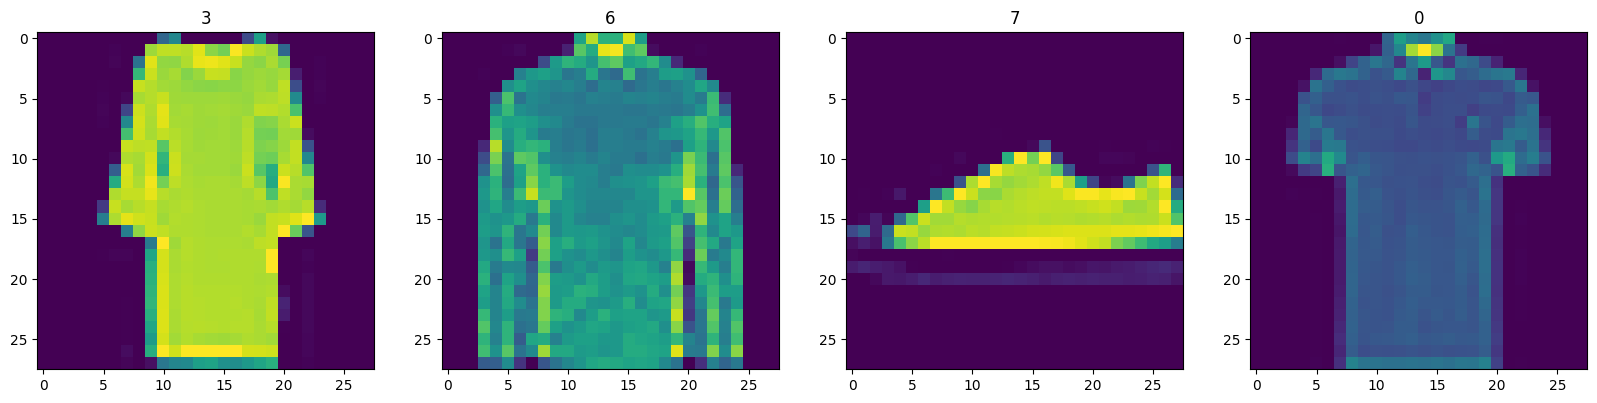

In [35]:
#setup subplot formatting ax- individual subplot
fig, ax = plt.subplots(ncols=4, figsize = (20,20))

#loop four time & get images
for idx in range(4):

    #grab an image & label
    batch = dataiterator.next()
    
    #plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(batch['image']))

    #appending the image label as the plot title
    ax[idx].title.set_text(batch['label'])

In [36]:
#scale and return images between 0 & 1
def scale_images(data):
    image = data['image']
    return image/255

Build a data pipeline

In [37]:
#reload te dataset
ds = tfds.load('fashion_mnist', split='train')
#running the image through the scale_image preprocessing step
ds = ds.map(scale_images)
#cache the datset for that batch
ds = ds.cache()
#shuffle it up
ds = ds.shuffle(60000)
#batch into 128 images per sample
ds = ds.batch(128)
#reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [38]:
#check the shape of the data
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## Build Neural Network

In [41]:
#import modeling components (bring in sequential api for the generator & discriminator)
from tensorflow.keras.models import Sequential

#bring in layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

Build Generator

In [80]:
def build_generator():
    model = Sequential()

    #takes in random values & reshapes it to 7*7*128
    #beginnings of a generated images
    model.add(Dense(7*7*128, input_dim = 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    #upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    #upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(1, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    #Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))    

    #Convolutional block 2
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    #conv layer to get to one channel
    model.add(Conv2D(1,4, padding='same', activation='sigmoid'))
    
    return model

In [81]:
generator = build_generator()

C:\Users\ibrahim.fadhili\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [82]:
generator.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_45 (LeakyReLU)      │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_15 (Reshape)            │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_18 (UpSampling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 14, 14, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_46 (LeakyReLU)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_19 (UpSampling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 1)      │         3,201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_47 (LeakyReLU)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 28, 28, 128)    │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_48 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 28, 28, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_49 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 28, 28, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,635,970 (6.24 MB)

 Trainable params: 1,635,970 (6.24 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
img = generator.predict(np.random.randn(4,128,1))
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


array([[[[0.5005145 ],
         [0.500089  ],
         [0.5002984 ],
         ...,
         [0.49929056],
         [0.50003606],
         [0.5004447 ]],

        [[0.5004333 ],
         [0.5008126 ],
         [0.50015855],
         ...,
         [0.49988425],
         [0.500177  ],
         [0.5003355 ]],

        [[0.49954107],
         [0.50005335],
         [0.5006558 ],
         ...,
         [0.49913162],
         [0.49955255],
         [0.5003135 ]],

        ...,

        [[0.49965128],
         [0.49876988],
         [0.49974415],
         ...,
         [0.5009832 ],
         [0.5001364 ],
         [0.5005502 ]],

        [[0.49809605],
         [0.4988442 ],
         [0.49958065],
         ...,
         [0.49915186],
         [0.49970958],
         [0.50022584]],

        [[0.49927354],
         [0.5005126 ],
         [0.49964997],
         ...,
         [0.5009876 ],
         [0.500865  ],
         [0.5002324 ]]],


       [[[0.49990767],
         [0.5002939 ],
         [0.49

In [85]:
img.shape

(28, 28, 1)

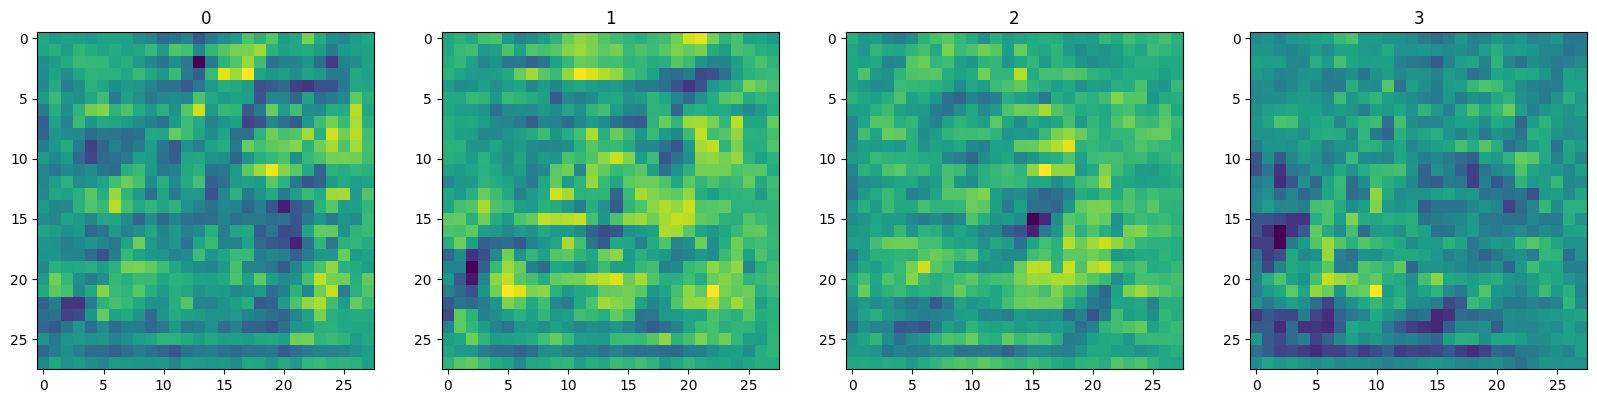

In [84]:
#setup subplot formatting ax- individual subplot
fig, ax = plt.subplots(ncols=4, figsize = (20,20))

#loop four time & get images
for idx, img in enumerate (img):

    #plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))

    #appending the image label as the plot title
    ax[idx].title.set_text(idx)